# Fáza 2

Pokračujeme vo fáze 2 tak ako sme sa rozhodli vo fáze 1. To znamená ze pokračujeme projekt iba z dátami measurements.csv a dáta zo stations.csv nepoužívame.

### Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kstest, norm, shapiro
from scipy.stats import mannwhitneyu, levene
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

# Integracia a cistenie dát

### Technika 1 - odstranenie chybnych hodnot a outliers

In [2]:
measurements = pd.read_csv("data/measurements.csv", delim_whitespace=True)
print(f"Pocet zaznamov v datach pred cistenym: {len(measurements)}")
def remove_outliers(col, data):
    data.reset_index(drop=True, inplace = True)
    data_mean = data[col].mean()
    data_std = data[col].std()
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    
    i = 0
    while (len(data)-1) != i:
        if data[col].iloc[i] < lower or data[col].iloc[i] > upper:
            data.drop(i, axis = 0)
        i+= 1
    return data

def remove_data(origin):
    origin = origin.drop(['latitude', 'longitude'], axis=1)
    origin = origin.dropna()
    origin.drop(origin[(origin['warning'] != 1) | (origin['warning'] != 0)].index, axis=0)
    origin = origin.drop(origin[origin.duplicated()].index)
    
    for col in origin.columns:
        if col != 'warning':
            origin = remove_outliers(col, origin)
    return origin
    
data_removed = remove_data(measurements)
print(f"Pocet zaznamov po cisteny dat: {len(data_removed)}")


def find_outliers(col):
    data_mean = data_removed[col].mean()
    data_std = data_removed[col].std()
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers = [x for x in data_removed[col] if x < lower or x > upper]

    return len(outliers)

Pocet zaznamov v datach pred cistenym: 12155
Pocet zaznamov po cisteny dat: 11273


Z dat sme odstranily nepotrebne stlce, prazdne hodnoty, chybne hodnoty attributu "warning", duplicovane zaznamy a outliers

### Technika 2 - nahradenie chybnych hodnot a outliers

In [3]:
measurements = pd.read_csv("data/measurements.csv", delim_whitespace=True)

def replace_warning(measurements):
    for i in range(len(measurements)):
        if measurements['warning'].iloc[i] >= 0.5:
            measurements["warning"].iloc[i] = 1
        else:
            measurements["warning"].iloc[i] = 0
    return measurements
    

def replace_outliers(col, measurements):
    data_mean = measurements[col].mean()
    data_std = measurements[col].std()
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    
    for i in range(len(col)):
        if measurements[col].iloc[i] < lower:
            measurements[col].iloc[i] = lower
        elif measurements[col].iloc[i] > upper:
            measurements[col].iloc[i] = upper
            
    return measurements
    
    
def replace_data(measurements):
    measurements = measurements.drop(['latitude', 'longitude'], axis=1)
    measurements = replace_warning(measurements)
    measurements.fillna(measurements.mean(), inplace = True)
    measurements = measurements.drop(measurements[measurements.duplicated()].index)
    
        
    for col in measurements.columns:
        if col != 'warning':
            measurements = replace_outliers(col, measurements)
    
    return measurements

V datach sme zmenili hodnoty warning ktore boli vatsia ako 0.5 na 1. Ostatne sme nastavali na 0. Prazdne hodnoty sa nastavali na ich priemerne a duplicitne merania sme stale odstranili pretoze tie nepotrebuje.

Kedze po odstraneni hodnot nam stale zostalo velke mnozstvo merani rozhodli sme sa pokracovat s technikou 1. Pretoze hodnota warning je najdolezitejsia a nevieme v pripade ked bola chybna ci jej reprezentacia moze stale byt opravena pomocou zaokruhlenia.

# Realizácia predspracovania dát 

## Rozdelenie dat

Data rozdelime na 2 casty. 1. cast su training data ktore pouzijeme na trenovanie nasho modelu (tvori 75% dat). 
2. cast su data na ktorej budeme model testovat (zvysnich 25%)

In [4]:
training_data = data_removed.sample(frac=0.75, random_state=25)
testing_data = data_removed.drop(training_data.index)

training_data_target = training_data["warning"]
training_data_features = training_data.loc[:,training_data.columns != 'warning']
# training_data_features = training_data[['CO', 'SO2', 'PM10']]

testing_data_target = testing_data["warning"]
testing_data_features = testing_data.loc[:,training_data.columns != 'warning']

Po rozdeleni nam vznikaju features a target. Pomocou features ('CO, SO2, O3') by sme mali vediet mali vediet predikovat hodnotu target ('warning') potom ako naucime model.

## Transformacia dat

Transformacia dat sluzi na predspracovanie udajov pre strojove ucenie. Kedze nase data su iba numericke budeme pouzivat metody scaling.

Technika 1 - StandarScaler

In [5]:
scaler = StandardScaler()
training_data_features_standard = scaler.fit_transform(training_data_features)

Technika 2 - PowerTransformer

In [6]:
power = PowerTransformer(method='yeo-johnson', standardize=True) 
training_data_features_transform = power.fit_transform(training_data_features)

### Vizualizacia

<AxesSubplot: ylabel='Count'>

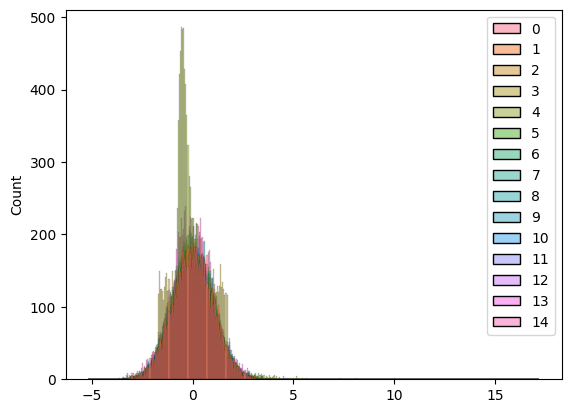

In [7]:
sns.histplot(training_data_features_standard)

<AxesSubplot: ylabel='Count'>

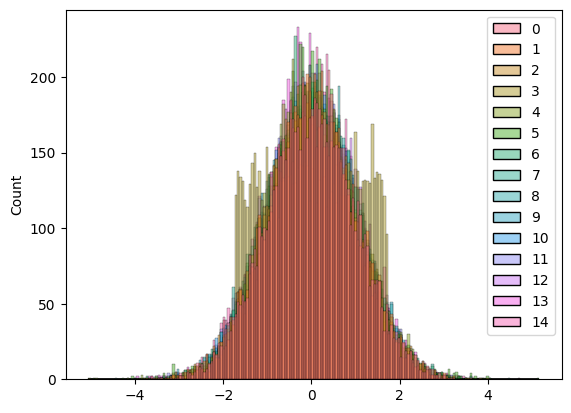

In [8]:
sns.histplot(training_data_features_transform)

Z vizualizacie mozeme vidiet ze Powertransformation nam transformuje data na konzistensiu formu ako StandardScaler. Preto budeme pokracovat s technikou 2.

# Výber atribútov pre strojové učenie

In [9]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
sfs = SequentialFeatureSelector(knn, n_features_to_select=5, direction="forward")
sfs.fit(training_data_features_transform, y=training_data_target)
X_selection = sfs.transform(training_data_features_transform)

Na vyber features pouzijeme SequentailFeatureSelector s KNN enstimatorom ktori nam vrati 5 najrelevatnejsich features ktore ovplivnuju hodnotu warning

In [10]:
sfs.get_feature_names_out(input_features=training_data_features.columns)

array(['PM2.5', 'PAHs', 'CO', 'SO2', 'NOx'], dtype=object)

Kedze metoda get_feature_names_out nezoraduje vybrate features podla relevancie nizsie sme ich manualne zoradili tak, ze sme postupne zvacsovali argument n_features_to_select o 1 a zapisovali nove features ktore pribudali

#### Zoradene features podla relevantnosti : SO2, CO, NOx, PM2.5, PAHs

# Replikovateľnosť predspracovania

### Vytvorenie pipeline

In [11]:
pipeline = make_pipeline(SimpleImputer(strategy = 'median'),PowerTransformer(method='yeo-johnson', standardize=True),SequentialFeatureSelector(KNeighborsClassifier(n_neighbors=3), n_features_to_select=5, direction="forward"), LinearRegression() )   

Pipeline nakoniec vytvoreme taku ze prazdne hodnoty sa zaplnia ich strednout hodnotou. Data sa pretransformuju pomocou PowerTransformer. Najdeme 5 najrelevantnejsich featurov a potom vypocita LinearRegression.

In [12]:
pipeline.fit(training_data_features,training_data_target)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('powertransformer', PowerTransformer()),
                ('sequentialfeatureselector',
                 SequentialFeatureSelector(estimator=KNeighborsClassifier(n_neighbors=3),
                                           n_features_to_select=5)),
                ('linearregression', LinearRegression())])

In [13]:
target_prediction = pipeline.predict(testing_data_features)
test_acc = pipeline.score(testing_data_features,testing_data_target)
print(f'Test accuracy: {test_acc:.3f}')

Test accuracy: 0.537


Pipeline teda fitneme data a potom z nich vieme spravit predikciu

Percentuálny podieľ práce 50/50

Matúš Rusňák, Jaroslav Samuel Griščík